In [77]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torchvision
import os

IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)
BATCH_SIZE = 64


train_tfms = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),])

val_tfms = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),])


# Datasets from torch
train_ds = datasets.Food101(root="data",split="train",download=True,transform=train_tfms)
val_ds = datasets.Food101(root="data",split="test",download=True,transform=val_tfms)


train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE,
    shuffle=True, num_workers=min(4, os.cpu_count()), pin_memory=True , persistent_workers=True, prefetch_factor=2)

val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE*2,
    shuffle=False, num_workers=min(4, os.cpu_count()), pin_memory=True , persistent_workers=True)

x, y = next(iter(train_loader))
print(f"Batch de imágenes: {x.shape}")
print(f"Batch de etiquetas: {y.shape}")

Batch de imágenes: torch.Size([64, 3, 200, 200])
Batch de etiquetas: torch.Size([64])


In [17]:
print(f"Número de imágenes en el conjunto de entrenamiento: {len(train_ds)}")
print(f"Número de imágenes en el conjunto de validación: {len(val_ds)}")

Número de imágenes en el conjunto de entrenamiento: 75750
Número de imágenes en el conjunto de validación: 25250


In [11]:
num_classes = len(train_ds.classes)
print(f"Número de clases: {num_classes}")
print("Primeras 10 clases:", train_ds.classes[:10])

Número de clases: 101
Primeras 10 clases: ['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito']


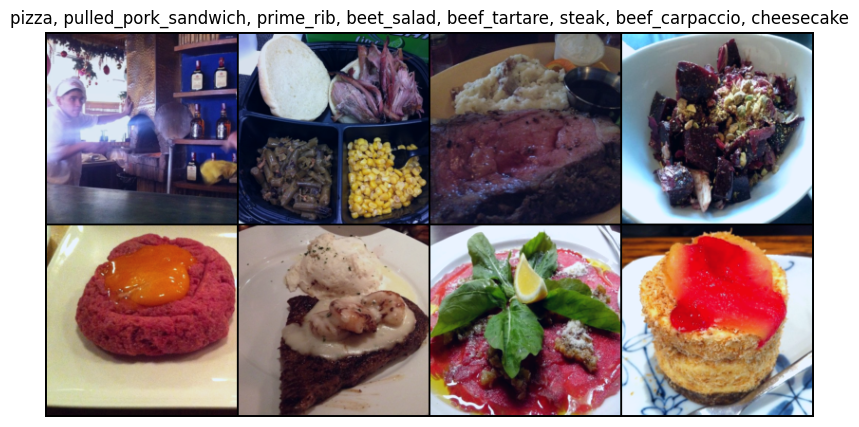

In [78]:

def imshow_batch(images, labels, classes, n=8):
    img_grid = torchvision.utils.make_grid(images[:n], nrow=4, normalize=True)
    plt.figure(figsize=(10,5))
    plt.imshow(img_grid.permute(1,2,0))
    plt.axis('off')
    plt.title(", ".join(classes[i] for i in labels[:n]))
    plt.show()

imshow_batch(x, y, train_ds.classes)

# Model

In [28]:
import math
import torch.nn.functional as F
from dataclasses import dataclass

@dataclass
class CompoundScaler:
    """
    Escala compuesta de EfficientNet.
    Controla cómo crecen ancho, profundidad y resolución según φ.
    """
    def __init__(self, phi: int = 0, alpha: float = 1.2, beta: float = 1.1, gamma: float = 1.15):
        self.phi = phi
        self.alpha = alpha  # depth
        self.beta = beta    # width
        self.gamma = gamma  # resolution

    def width_mult(self):
        return self.beta ** self.phi

    def depth_mult(self):
        return self.alpha ** self.phi

    def res_mult(self):
        return self.gamma ** self.phi

def round_filters(c_out, width_mult, divisor = 8, min_width = None):
    """
    Redondea canales al múltiplo de 'divisor' (como EfficientNet).
    Se asegura de no reducir más de un 10% respecto a c_out * width_mult.
    """
    if min_width is None:
        min_width = divisor
    new_c = c_out * width_mult
    new_c = max(min_width, int(new_c + divisor / 2) // divisor * divisor)
    # Evita caer demasiado por redondeo:
    if new_c < 0.9 * c_out * width_mult:
        new_c += divisor
    return int(new_c)

def round_repeats(n, depth_mult):
    """
    Redondea repeticiones al entero hacia arriba.
    """
    return int(math.ceil(n * depth_mult))


def round_resolution(base_size, res_mult: float, divisor = 8, clamp = None):
    """
    Escala resolución base y redondea al múltiplo de 'divisor'.
    Opcionalmente, limita el rango con 'clamp=(min,max)'.
    """
    size = int(round(base_size * res_mult))
    size = max(divisor, int(round(size / divisor) * divisor))
    if clamp is not None:
        lo, hi = clamp
        size = max(lo, min(size, hi))
    return size

class DynamicResize(torch.nn.Module):
    """
    Reescala un batch NCHW a la resolución target (H=W=target_size)
    mediante F.interpolate (mode='bilinear' por defecto).
    """
    def __init__(self, mode: str = "bilinear", align_corners: bool = False):
        super().__init__()
        self.mode = mode
        self.align_corners = align_corners

    @torch.no_grad()
    def forward(self, x: torch.Tensor, target_size: int) -> torch.Tensor:
        # x: [N, C, H, W]
        if x.shape[-1] == target_size and x.shape[-2] == target_size:
            return x
        return F.interpolate(x, size=(target_size, target_size),mode=self.mode, align_corners=self.align_corners)


# Test:
base_input_size = 200
scaler = CompoundScaler(alpha=1.2, beta=1.1, gamma=1.15, phi=0)

# Resolución para B0:
res_b0 = round_resolution(base_input_size, scaler.res_mult(), divisor=8)
print("B0 size:", res_b0)

# Cambiemos a B4 (phi=4) para ilustrar:
scaler.phi = 4
depth_m = scaler.depth_mult()
width_m = scaler.width_mult()
res_b4 = round_resolution(base_input_size, scaler.res_mult(), divisor=8)

print("Multiplicadores -> depth:", round(depth_m, 3),
          " width:", round(width_m, 3),
          " res_mult:", round(scaler.res_mult(), 3))
print("B4 size:", res_b4)

# Redondeo de canales/repeticiones de un bloque ejemplo:
base_c = 40
base_n = 2
c_b4 = round_filters(base_c, width_m, divisor=8)
n_b4 = round_repeats(base_n, depth_m)
print(f"Canales etapa (B4): {c_b4}  |  Reps etapa (B4): {n_b4}")

# Reescalar un batch simulado NCHW:
x = torch.randn(8, 3, base_input_size, base_input_size)
resizer = DynamicResize()
x_b4 = resizer(x, target_size=res_b4)
print("x :", tuple(x.shape))
print("x_b4:", tuple(x_b4.shape))

B0 size: 200
Multiplicadores -> depth: 2.074  width: 1.464  res_mult: 1.749
B4 size: 352
Canales etapa (B4): 56  |  Reps etapa (B4): 5
x : (8, 3, 200, 200)
x_b4: (8, 3, 352, 352)


In [42]:
import torch.nn as nn

def get_same_pad(kernel_size: int, stride: int, dilation: int = 1):
    # para kernels impares típicos (3,5), same padding = floor((k-1)/2) cuando stride=1
    # para stride>1, replicamos el "same" de TF con ZeroPad2d dinámico (ver ConvBNAct abajo)
    pad = (kernel_size - 1) // 2 * dilation
    return pad

def calc_pad_2d(x: torch.Tensor, kernel_size: int, stride: int, dilation: int = 1):
    # calcula padding (top,bottom,left,right) para emular 'same' al downsamplear
    h, w = x.shape[-2:]
    out_h = math.ceil(h / stride)
    out_w = math.ceil(w / stride)
    pad_h = max((out_h - 1) * stride + (kernel_size - 1) * dilation + 1 - h, 0)
    pad_w = max((out_w - 1) * stride + (kernel_size - 1) * dilation + 1 - w, 0)

    # repartir padding en ambos lados
    pad_top = pad_h // 2
    pad_bottom = pad_h - pad_top
    pad_left = pad_w // 2
    pad_right = pad_w - pad_left
    return (pad_left, pad_right, pad_top, pad_bottom)


def make_divisible(v: float, divisor: int, min_value = None):
    """
    Redondea 'v' al múltiplo de 'divisor' sin caer >10% por debajo.
    (Estilo MobileNet/EfficientNet).
    """
    if divisor <= 0:
        return max(1, int(v))
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    if new_v < 0.9 * v:
        new_v += divisor
    return int(new_v)


class ConvBNAct(nn.Module):
    """
    Conv2d (+ ZeroPad2d para SAME con stride>1 opcional) + BatchNorm2d + SiLU
    Puede actuar como:
      - expand 1x1: kernel=1, stride=1, groups=1
      - depthwise: kernel=3/5, stride=1/2, groups=in_channels
    """
    def __init__(self, in_ch: int, out_ch: int,
        kernel_size: int = 1,
        stride: int = 1,
        groups: int = 1,
        use_act: bool = True,
        bn_eps: float = 1e-3,
        bn_mom: float = 0.99,):

        super().__init__()
        self.kernel_size = kernel_size
        self.stride = stride
        self.dilation = 1
        self.use_act = use_act
        self.groups = groups

        # Determina si necesita padding dinámico (solo stride > 1)
        self.use_dynamic_pad = stride > 1

        # same pading si stride = 1
        if stride == 1:
          pad = get_same_pad(kernel_size, stride, self.dilation)
        else:
          pad = 0

        self.pad_layer = None

        # Forward Pass bones
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size=kernel_size,stride=stride,
            padding=pad, dilation=self.dilation, groups=groups,bias=False)
        self.bn = nn.BatchNorm2d(out_ch, eps=bn_eps, momentum=bn_mom)

        if use_act:
          self.act = nn.SiLU(inplace=True)
        else:
          self.act = nn.Identity()

    def forward(self, x):
        if self.use_dynamic_pad:
            # calcular padding "same" en tiempo de ejecución
            l, r, t, b = calc_pad_2d(x, self.kernel_size, self.stride, self.dilation)
            if (l or r or t or b):
                x = F.pad(x, (l, r, t, b))

        # Forward
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        return x


class SqueezeExcitation(nn.Module):
    """
    Squeeze-and-Excitation (SE) block.
    GAP -> 1x1 reduce (C*r) -> SiLU -> 1x1 expand (C) -> Sigmoid -> channel reweight.
    EficientNet usa típicamente se_ratio=0.25 y redondeo divisible por 8.
    """

    def __init__(self, in_ch_after_expand: int,  # = mid_ch (entrada real al SE)
                 se_hidden_from: int,            # = in_ch (antes del expand)
                 se_ratio: float = 0.25,
                 divisible_by: int = 8):
        super().__init__()

        # canales ocultos (al menos 1, y divisible por 'divisible_by')
        hidden_raw = max(1, int(se_hidden_from * se_ratio))
        hidden = make_divisible(hidden_raw, divisible_by) if divisible_by > 0 else hidden_raw
        hidden = min(hidden, in_ch_after_expand)

        self.pool = nn.AdaptiveAvgPool2d(1)  # N,C,1,1

        # bottleneck (reduce -> SiLU -> expand)
        self.reduce = nn.Conv2d(in_ch_after_expand, hidden, 1)
        self.act = nn.SiLU(inplace=True)
        self.expand = nn.Conv2d(hidden, in_ch_after_expand, 1)

        self.gate = nn.Sigmoid()

    def forward(self, x: torch.Tensor):
        s = self.pool(x)
        s = self.reduce(s)
        s = self.act(s)
        s = self.expand(s)
        s = self.gate(s)
        return x * s  # reescala canal-a-canal


class StochasticDepth(nn.Module):
    """
    Stochastic Depth / Drop-Connect del ramo principal (main path).
    En entrenamiento, con prob p se "apaga" el bloque (x) y se deja pasar el skip (residual).
    En inferencia, se desactiva (equivale a x + residual).
    """
    def __init__(self, p: float = 0.0):
        super().__init__()
        self.p = float(p)


    def forward(self, x, residual):
        if (not self.training) or self.p == 0.0:
            return x + residual

        keep = 1.0 - self.p
        # máscara por muestra (N,1,1,1)
        mask = torch.empty((x.shape[0], 1, 1, 1), device=x.device, dtype=x.dtype).bernoulli_(keep)
        x = x * (mask / keep)
        return x + residual

class MBConv(nn.Module):
    """
    MBConv (EfficientNet v1):
      x -> [Expand 1x1 (t)] -> [Depthwise kxk] -> [SE] -> [Project 1x1 (linear)]
      + residual si stride==1 y C_in==C_out (con stochastic depth opcional).

    Args:
        in_ch: canales de entrada
        out_ch: canales de salida
        kernel_size: {3,5,7}
        stride: {1,2}
        expand_ratio: puede ser int o float (t); si ==1 no hay expand
        se_ratio: típicamente 0.25 en EfficientNet
        drop_connect: prob. de stochastic depth para ESTE bloque (programada fuera)
        bn_eps, bn_mom: BatchNorm estilo TF (1e-3, 0.99)
        divisible_by: redondeo de canales (8 por defecto, estilo EfficientNet/MobileNet)
    """

    def __init__(self,in_ch: int, out_ch: int, kernel_size: int = 3,stride: int = 1,
        expand_ratio: int = 6,
        se_ratio: float = 0.25,
        drop_connect: float = 0.0,
        bn_eps: float = 1e-3,
        bn_mom: float = 0.99 , divisible_by: int = 8):

        super().__init__()
        assert stride in (1, 2), "stride debe ser 1 o 2"
        assert kernel_size in (3, 5, 7) , "kernel_size debe ser 3, 5 o 7"


        self.use_residual = (stride == 1 and in_ch == out_ch)

        # canales intermedios (expand)
        t = float(expand_ratio)
        if t <= 1.0 + 1e-8:
            mid_ch = in_ch
            self.expand = nn.Identity()
        else:
            mid_ch = make_divisible(in_ch * t, divisible_by)
            self.expand = ConvBNAct(
                in_ch=in_ch, out_ch=mid_ch,
                kernel_size=1, stride=1, groups=1,
                use_act=True, bn_eps=bn_eps, bn_mom=bn_mom)

        # Depthwise
        self.depthwise = ConvBNAct(mid_ch, mid_ch, kernel_size=kernel_size, stride=stride, groups=mid_ch,
            use_act=True, bn_eps=bn_eps, bn_mom=bn_mom)

        # SE
        self.se = SqueezeExcitation(in_ch_after_expand=mid_ch, se_hidden_from=in_ch,
            se_ratio=se_ratio,divisible_by=divisible_by)

        # Project (1x1, sin activación)
        self.project = ConvBNAct(mid_ch, out_ch, kernel_size=1, stride=1, groups=1,
            use_act=False, bn_eps=bn_eps, bn_mom=bn_mom)

        # Stochastic depth
        if self.use_residual and drop_connect > 0.0:
          self.sd = StochasticDepth(drop_connect)
        else:
          self.sd = None

    def forward(self, x: torch.Tensor):
        identity = x if self.use_residual else None

        x = self.expand(x)
        x = self.depthwise(x)
        x = self.se(x)
        x = self.project(x)

        if self.use_residual:
            if self.sd is not None:
                x = self.sd(x, identity)
            else:
                x = x + identity

        return x


# EfficentNet V1

In [43]:
class EfficientNet(nn.Module):
    """
    EfficientNet v1 paramétrico (B0..B7) con compound scaling.
    - Define B0 base mediante la tabla (t,k,c,n,s)
    - Aplica round_filters (ancho) y round_repeats (profundidad) con width/depth multipliers
    - Distribuye drop_connect linealmente a lo largo de todos los MBConv
    """

    # Tabla B0: (expand t, kernel k, out_channels c, repeats n, stride s)
    B0_CFG = [
        (1, 3,  16, 1, 1),
        (6, 3,  24, 2, 2),
        (6, 5,  40, 2, 2),
        (6, 3,  80, 3, 2),
        (6, 5, 112, 3, 1),
        (6, 5, 192, 4, 2),
        (6, 3, 320, 1, 1),]

    def __init__(self, num_classes: int = 101,
                 scaler: CompoundScaler = CompoundScaler(),
                 se_ratio: float = 0.25,
                 drop_connect_rate: float = 0.2,
                 dropout: float = 0.2,
                 stem_channels: int = 32,
                 head_channels: int = 1280,
                 channel_divisor: int = 8,
                 bn_eps: float = 1e-3,
                 bn_mom: float = 0.01): # IMPORTANTE: en PyTorch, 0.01 ≈ TF 0.99

        super().__init__()

        width_mult = scaler.width_mult()
        depth_mult = scaler.depth_mult()
        stem_c = round_filters(stem_channels, width_mult, channel_divisor)
        head_c = round_filters(head_channels, width_mult, channel_divisor)

        # Stem
        self.stem = ConvBNAct(3, stem_c, kernel_size=3, stride=2, groups=1,use_act=True, bn_eps=bn_eps, bn_mom=bn_mom)

        # MBConv stages
        total_blocks = 0
        repeats_per_stage = []
        for (t, k, c, n, s) in self.B0_CFG:
            n_round = round_repeats(n, depth_mult)
            repeats_per_stage.append(n_round)
            total_blocks += n_round

        # MBConv stages
        blocks = []
        block_idx = 0
        in_ch = stem_c

        for stage_idx, (t, k, c, n, s) in enumerate(self.B0_CFG):
            out_c = round_filters(c, width_mult, channel_divisor)
            repeats = repeats_per_stage[stage_idx]

            for i in range(repeats):
                stride_i = s if i == 0 else 1
                # escala lineal de drop_connect en profundidad
                denom = max(1, total_blocks - 1)
                drop_i = drop_connect_rate * (block_idx / denom)

                blocks.append(MBConv(
                    in_ch=in_ch,
                    out_ch=out_c,
                    kernel_size=k,
                    stride=stride_i,
                    expand_ratio=float(t),
                    se_ratio=se_ratio,
                    drop_connect=drop_i,
                    bn_eps=bn_eps,
                    bn_mom=bn_mom,
                    divisible_by=channel_divisor))

                in_ch = out_c
                block_idx += 1

        self.blocks = nn.Sequential(*blocks)

        # Head
        self.head = ConvBNAct(in_ch, head_c, kernel_size=1, stride=1, groups=1,
                              use_act=True, bn_eps=bn_eps, bn_mom=bn_mom)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.drop = nn.Dropout(p=dropout, inplace=True) if dropout > 0 else nn.Identity()
        self.fc = nn.Linear(head_c, num_classes)

        # Pesos por defecto
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight); nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01); nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.stem(x)
        x = self.blocks(x)
        x = self.head(x)
        x = self.pool(x)           # (N, C, 1, 1)
        x = torch.flatten(x, 1)    # (N, C)
        x = self.drop(x)
        x = self.fc(x)
        return x


## Train lopp

In [79]:
from torch.nn.functional import cross_entropy
from sklearn.metrics import f1_score
import torch


def make_grad_scaler(device_type: str, enabled: bool = True):
    """
    Crea un GradScaler sin disparar deprecations.
    - PyTorch nuevo: torch.amp.GradScaler(device_type='cuda'|'cpu', enabled=...)
    - PyTorch intermedio: torch.amp.GradScaler('cuda'|'cpu', enabled=...)  # firma antigua
    """
    # API moderna/unificada
    if hasattr(torch, "amp") and hasattr(torch.amp, "GradScaler"):
        try:
            # Firma nueva
            return torch.amp.GradScaler(device_type=device_type, enabled=enabled)
        except TypeError:
            # Firma vieja
            return torch.amp.GradScaler(device_type, enabled=enabled)

    # Ruta 2: muy antiguo (sin torch.amp)
    if device_type == "cuda":
        from torch.cuda.amp import GradScaler as CudaGradScaler
        return CudaGradScaler(enabled=enabled)


def train_efficientnet_multiclass(
    model,
    train_loader,
    optimizer,
    scheduler=None,
    num_epochs = 10,
    device= "cuda",
    label_smoothing: float = 0.0, # Para mejorar Cross Entropy
    grad_clip: float | None = 5.0,
    use_amp = True,
    # parámetros para compound scaling de resolución
    base_input_size: int = 200,     # 200x200 food 101
    scaler=None,                    # instancia CompoundScaler(phi=0..7)
    channel_divisor: int = 8,       # Controla el redondeo de canales en make_divisible / round_filters
    progressive: bool = False,      # si True: incrementa resolución progresivamente por época
):
    """
    Entrena EfficientNet (o cualquier CNN sin logits auxiliares), aplicando compound scaling de
    RESOLUCIÓN en el batch con DynamicResize. Mantiene AMP, label smoothing y grad clipping.

    - base_input_size: tamaño con el que llegan tus batches (p.ej., 200).
    - scaler: CompoundScaler(alpha,beta,gamma,phi). Usamos gamma**phi para la resolución target.
    - progressive: si True, incrementa suavemente la resolución desde base_input_size a target
      a lo largo de las épocas (útil para acelerar warmup).
    """
    device = torch.device(device)
    torch.set_float32_matmul_precision("high")
    model.to(device)
    model.to(memory_format=torch.channels_last)
    model.train()

    # AMP scaler
    scaler_amp = make_grad_scaler(device.type, enabled=use_amp)


    resizer = DynamicResize()
    # Calcula resolución objetivo a partir de gamma^phi (si hay scaler)
    if scaler is not None:
        res_mult = (scaler.gamma ** scaler.phi)
    else:
        res_mult = 1.0

    target_size_full = round_resolution(base_input_size, res_mult, divisor=channel_divisor)

    history = {"train_loss": [], "train_acc": [], "train_f1_macro": []}

    autocast_dtype = torch.float16 if device.type == "cuda" else torch.bfloat16
    for epoch in range(num_epochs):
        epoch_loss, correct, total = 0.0, 0, 0
        y_true_train, y_pred_train = [], []

        # Si entrenamiento progresivo: interpola linealmente el tamaño por época
        if progressive:
            t = (epoch + 1) / num_epochs
            t_smooth = 0.5 * (1 - torch.cos(torch.tensor(t * 3.14159265))).item()
            curr_size = int(round(base_input_size + t_smooth * (target_size_full - base_input_size)))
            curr_size = max(channel_divisor, int(round(curr_size / channel_divisor) * channel_divisor))
        else:
            curr_size = target_size_full

        for X, y in train_loader:
            X = X.to(device, non_blocking=True).to(memory_format=torch.channels_last)
            y = y.to(device, non_blocking=True)

            # compound scaling de resolución en el batch
            if (X.shape[-2] != curr_size) or (X.shape[-1] != curr_size):
                X = resizer(X, target_size=curr_size) # escalamos las imaganes segun el factor

            optimizer.zero_grad(set_to_none=True)


            use_autocast = use_amp and device.type in {"cuda", "cpu"}
            autocast_kwargs = {"device_type": device.type,"dtype": torch.float16 if device.type == "cuda" else torch.bfloat16,
                              "enabled": use_autocast}
            if device.type == "cpu":
                autocast_kwargs["dtype"] = torch.bfloat16


            with torch.autocast(**autocast_kwargs):
                logits = model(X)
                loss = F.cross_entropy(logits, y, label_smoothing=label_smoothing) # Definimos directamente Corssentropy aca
                preds = logits.argmax(dim=1)

            # Backprop
            if scaler_amp and scaler_amp.is_enabled():
                scaler_amp.scale(loss).backward()
                if grad_clip is not None:
                    scaler_amp.unscale_(optimizer)
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=grad_clip)
                scaler_amp.step(optimizer)
                scaler_amp.update()
            else:
                loss.backward()
                if grad_clip is not None:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=grad_clip)
                optimizer.step()

            # métricas
            bs = y.size(0)
            epoch_loss += loss.item() * bs
            correct += (preds == y).sum().item()
            total += bs
            y_true_train.extend(y.detach().cpu().tolist())
            y_pred_train.extend(preds.detach().cpu().tolist())

        if scheduler is not None:
            scheduler.step()

        avg_train_loss = epoch_loss / total
        train_acc = correct / total
        train_f1 = f1_score(y_true_train, y_pred_train, average="macro")

        history["train_loss"].append(avg_train_loss)
        history["train_acc"].append(train_acc)
        history["train_f1_macro"].append(train_f1)

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"size:{curr_size} | Loss:{avg_train_loss:.4f} | Acc:{train_acc:.3f} | F1:{train_f1:.3f}")

    return history

## Definir Modelos

In [44]:
def count_parameters(model: nn.Module, trainable_only: bool = True):
    """
    Cuenta los parámetros de un modelo PyTorch.

    Args:
        model (nn.Module): El modelo a analizar.
        trainable_only (bool): Si True, cuenta solo parámetros con requires_grad=True.
    Returns:
        int: Número total de parámetros.
    """
    if trainable_only:
        return sum(p.numel() for p in model.parameters() if p.requires_grad)
    else:
        return sum(p.numel() for p in model.parameters())

In [49]:
model_b0 = EfficientNet(num_classes=101, scaler=CompoundScaler(phi=0)) ## B0
total = count_parameters(model_b0, trainable_only=False)
trainable = count_parameters(model_b0, trainable_only=True)
print(f"Total de parámetros: {total:,}")
print(f"Parámetros entrenables: {trainable:,}")

x = torch.randn(2, 3, 200, 200)
y = model_b0(x)
print(y.shape)  # torch.Size([2, 101])

Total de parámetros: 5,323,920
Parámetros entrenables: 5,323,920
torch.Size([2, 1000])


In [52]:
model_b7 = EfficientNet(num_classes=101, scaler=CompoundScaler(phi=7)) ## B7
total = count_parameters(model_b7, trainable_only=False)
trainable = count_parameters(model_b7, trainable_only=True)
print(f"Total de parámetros: {total:,}")
print(f"Parámetros entrenables: {trainable:,}")

x = torch.randn(2, 3, 200, 200)
y = model_b7(x)
print(y.shape)  # torch.Size([2, 101])

Total de parámetros: 66,868,677
Parámetros entrenables: 66,868,677
torch.Size([2, 101])


---

In [81]:

from torch.optim import RMSprop
from torch.optim.lr_scheduler import ExponentialLR

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True

scaler_b0 = CompoundScaler(alpha=1.2, beta=1.1, gamma=1.15, phi=0)
model_b0 = EfficientNet(num_classes=101, scaler=scaler_b0 , drop_connect_rate=0.2).to(device)
base_batch_size = 64

lr = 0.256 * (base_batch_size / 256.0)
optimizer = RMSprop(model_b0.parameters(),lr=lr,momentum=0.9,
                    weight_decay=1e-5,eps=0.001,alpha=0.9)

gamma_per_epoch = 0.97 ** (1.0 / 2.4)
scheduler = ExponentialLR(optimizer, gamma=gamma_per_epoch)



In [ ]:
history_b0 = train_efficientnet_multiclass(
    model=model_b0,
    train_loader=train_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=30,
    label_smoothing=0.1,
    grad_clip=5.0,
    base_input_size=200,             # batches vienen 200x200
    scaler=scaler_b0,                # para gamma^phi en la resolución (B0 -> phi=0)
    channel_divisor=8)               # Para mejorar estabilidad del modelo en computo

## Test bottelneck

In [87]:
%pip -q install kornia

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 100.7 MB/s eta 0:00:00


In [ ]:
%pip uninstall -y pillow
%pip install --no-cache-dir pillow-simd

In [96]:
import os, time, torch
from PIL import ImageFile
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import kornia.augmentation as KA
import torch.nn.functional as F

ImageFile.LOAD_TRUNCATED_IMAGES = True
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)
BATCH_SIZE = 128
num_workers = min(4, os.cpu_count() or 2)
curr_size = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


train_tfms_cpu = transforms.Compose([
    transforms.Resize((curr_size, curr_size)),
    transforms.Lambda(lambda img: img.convert("RGB")),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)])

val_tfms_cpu = transforms.Compose([
    transforms.Resize((curr_size, curr_size)),
    transforms.Lambda(lambda img: img.convert("RGB")),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)])

train_ds = datasets.Food101(root="data", split="train", download=True, transform=train_tfms_cpu)
val_ds   = datasets.Food101(root="data", split="test",  download=True, transform=val_tfms_cpu)

train_loader = DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=num_workers, pin_memory=True,
    persistent_workers=False, prefetch_factor=2)

val_loader = DataLoader(
    val_ds, batch_size=BATCH_SIZE*2, shuffle=False,
    num_workers=num_workers, pin_memory=True,
    persistent_workers=False, prefetch_factor=2)

gpu_aug = KA.AugmentationSequential(
    KA.RandomHorizontalFlip(p=0.5),
    KA.ColorJitter(0.1, 0.1, 0.1, p=1.0),
    data_keys=["input"], same_on_batch=False).to(device)

it = iter(train_loader)
X, y = next(it)
for _ in range(5): X, y = next(it)

t0 = time.time()
for _ in range(50):
    X, y = next(it)
t_loader = (time.time() - t0) / 50

X = X.to(device, non_blocking=True).to(memory_format=torch.channels_last)
model_b0.eval()

with torch.autocast(device_type='cuda', dtype=torch.float16):
    _ = gpu_aug(X)

with torch.autocast(device_type='cuda', dtype=torch.float16):
    t0 = time.time()
    for _ in range(50):
        X2 = gpu_aug(X)
        _ = model_b0(X2)
    t_fw = (time.time() - t0) / 50

print(f"[V1 GPU-aug] Loader/iter: {t_loader*1000:.1f} ms | Forward(+aug)/iter: {t_fw*1000:.1f} ms")



[V1 GPU-aug] Loader/iter: 463.2 ms | Forward(+aug)/iter: 231.8 ms


In [94]:
import os, time, torch
from PIL import ImageFile
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import kornia.augmentation as KA

ImageFile.LOAD_TRUNCATED_IMAGES = True
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

def make_loader(num_workers, prefetch_factor, batch_size=64):
    tfms = transforms.Compose([
        transforms.Resize((200,200)),
        transforms.Lambda(lambda img: img.convert("RGB")),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),])
    ds = datasets.Food101(root="data", split="train", download=True, transform=tfms)
    return DataLoader(ds, batch_size=batch_size, shuffle=True,
                      num_workers=num_workers, pin_memory=True,
                      persistent_workers=False, prefetch_factor=prefetch_factor)

def bench_loader(loader, iters=80, warmup=8):
    it = iter(loader)
    # warmup
    for _ in range(warmup):
        _ = next(it)
    t0 = time.time()
    for _ in range(iters):
        _ = next(it)
    return (time.time() - t0) / iters

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gpu_aug = KA.AugmentationSequential(
    KA.RandomHorizontalFlip(p=0.5),
    KA.ColorJitter(0.1,0.1,0.1,p=1.0),
    data_keys=["input"],
    same_on_batch=False,).to(device)

candidates = [(1,2),(2,2),(2,4),(4,2),(4,4)]
results = []
for nw, pf in candidates:
    try:
        loader = make_loader(nw, pf, batch_size=64)
        t = bench_loader(loader)
        results.append((nw, pf, t))
        print(f"num_workers={nw}, prefetch={pf} -> Loader/iter: {t*1000:.1f} ms")
    except Exception as e:
        print(f"Config (nw={nw}, pf={pf}) falló: {e}")


num_workers=1, prefetch=2 -> Loader/iter: 362.8 ms
num_workers=2, prefetch=2 -> Loader/iter: 242.1 ms
num_workers=2, prefetch=4 -> Loader/iter: 251.5 ms


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


num_workers=4, prefetch=2 -> Loader/iter: 247.1 ms
num_workers=4, prefetch=4 -> Loader/iter: 257.4 ms
